In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by:    Margaret Duff (STFC-UKRI)
#                  Laura Murgatroyd (STFC-UKRI)
#                  Franck Vidal (STFC-UKRI)
# 

# CIL Preconditioner and step size methods demo

This notebook explores the impact of selecting different step sizes for gradient descent algorithms. We’ll review the available step size methods in the Core Imaging Library (CIL) and guide you through building custom step size strategies tailored to specific needs.

Additionally, the notebook introduces preconditioners—tools that transform a problem into a form more suitable for efficient numerical solving.

CIL’s step size methods and preconditioners offer substantial flexibility, enabling users to adapt and design algorithms customized to their unique optimisation challenges.


In [3]:
from cil.utilities import dataexample
from cil.utilities.display import show2D
from cil.recon import FDK
from cil.processors import TransmissionAbsorptionConverter, Slicer
import numpy as np
import matplotlib.pyplot as plt 
from cil.plugins.tigre import ProjectionOperator
from cil.optimisation.algorithms import GD
from cil.optimisation.functions import LeastSquares, L2NormSquared
from cil.optimisation.operators import MatrixOperator
from cil.optimisation.utilities import callbacks, StepSizeMethods, preconditioner, ArmijoStepSizeRule
from cil.framework import  VectorData

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'

## Load Data

In this example, we utilize CIL's simulated sphere data. To accelerate computations in this notebook, we extract a 2D slice from the 3D dataset. Additionally, we select a subset of angles to create a limited-angle reconstruction scenario. We will then compare the ground truth data with a filtered back projection (FBP) reconstruction under these limited-angle conditions.

New geometry:  2D Cone-beam tomography
System configuration:
	Source position: [     0., -20000.]
	Rotation axis position: [0., 0.]
	Detector position: [    0., 60000.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [128   1]
	Pixel size: [64. 64.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 60
	Angles 0-9 in degrees: [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.]
	Angles 50-59 in degrees: [300., 306., 312., 318., 324., 330., 336., 342., 348., 354.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (60, 128)
New geometry shape:  (60, 128)
FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



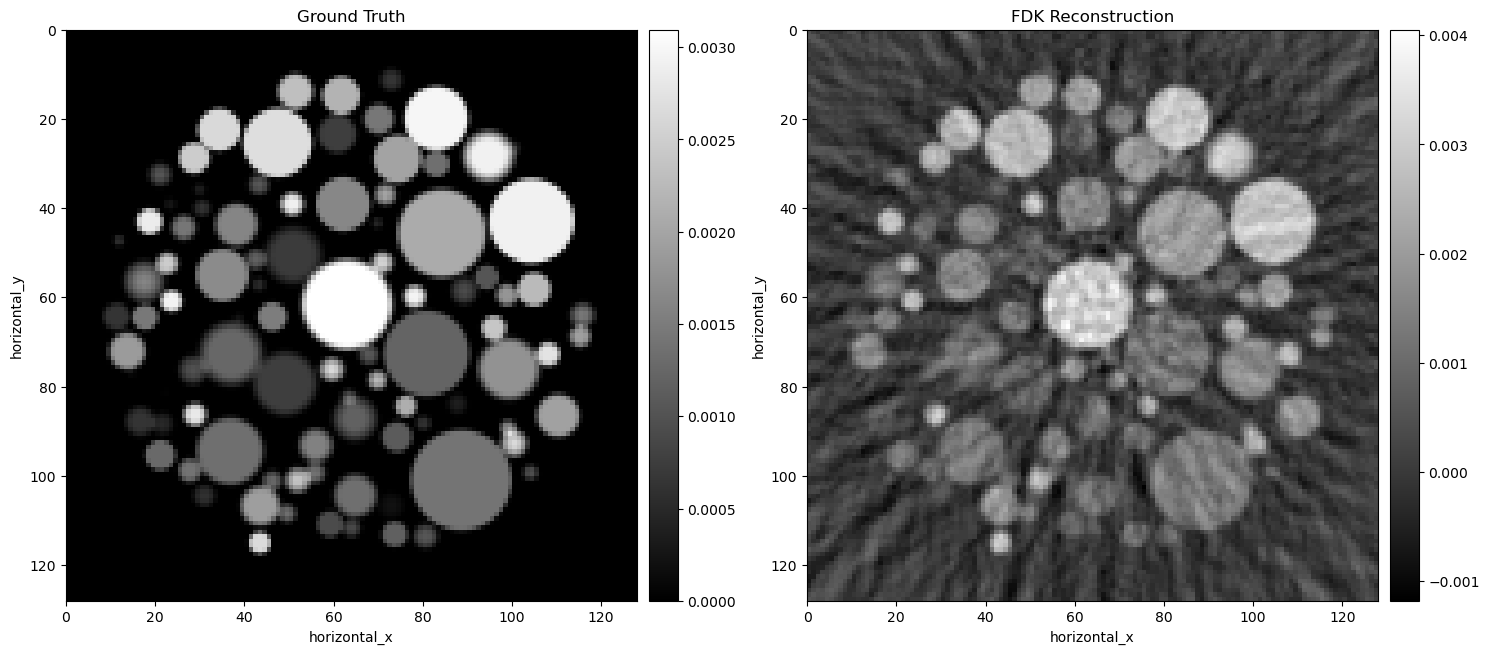

In [4]:
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()

data = data.get_slice(vertical='centre')
ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

recon = FDK(absorption, image_geometry=ig).run()
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);


## Gradient descent with a fixed step size 

We first consider regularising this limited angle CT reconstruction problem with L2 norm squared (also called Tikhonov) regularisation:
$$ \arg\min_x \|Ax-y\|_2^2 + \alpha \|x\|_2^2 $$ 
where $x$ is the image we wish to reconstruct, $A$ the forward CT operator and $y$ the measured data. The regularisation parameter $\alpha$ is chosen to balance the first, data discrepancy, term and the second, regularisation, term. 

As a starting point, consider solving this optimisation problem with an arbitrary fixed step size, 1e-6. 

  0%|          | 0/80 [00:00<?, ?it/s]

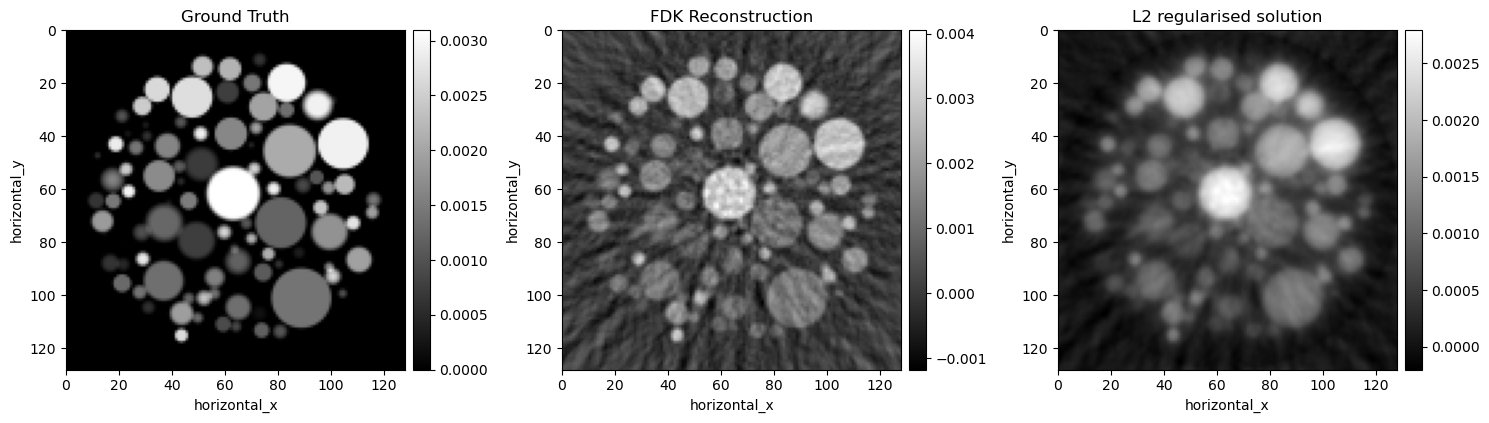

In [5]:
alpha=0.1   
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo_GD_fixed=GD(initial=ig.allocate(0), f=F, step_size=1e-7)
algo_GD_fixed.run(80)
show2D([ground_truth, recon, algo_GD_fixed.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3);


We now plot the objective value, $\|Ax-y\|_2^2 + \alpha \|x\|_2^2$, against iteration number to look at the speed of convergence of this algorithm. 

Text(0, 0.5, 'Objective value')

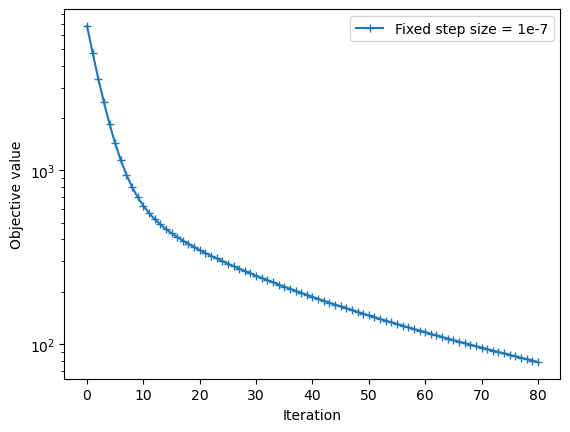

In [6]:
plt.plot(range(0,81),algo_GD_fixed.objective, label='Fixed step size = 1e-7', marker='+')
plt.legend()
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')

Now consider a more sensible choice of fixed step size, the reciprocal of the Lipschitz constant of $\|Ax-y\|_2^2 + \alpha \|x\|_2^2$. The **Lipschitz constant** is a value that quantifies the maximum rate of change of a function. For a function $ f $ to be Lipschitz continuous, there must exist a constant $ L $ (the Lipschitz constant) such that for any two points $ x $ and $ y $, the inequality $ |f(x) - f(y)| \leq L |x - y| $ holds. 

In optimization, the Lipschitz constant is often used to set a safe step size for gradient descent. In CIL, where it is available or easily calculable, the Lipschitz constant of a function is stored as property of the CIL function, for more info see the documentation: https://tomographicimaging.github.io/CIL/nightly/optimisation/#cil.optimisation.functions.Function.L

  0%|          | 0/80 [00:00<?, ?it/s]

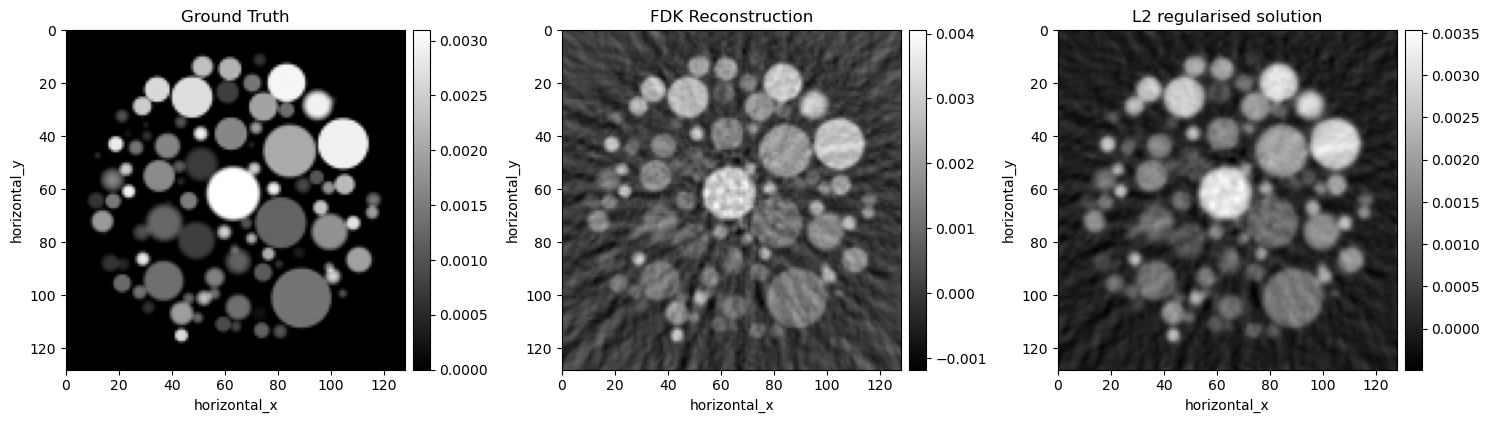

In [7]:

algo_GD_lip=GD(initial=ig.allocate(0), f=F, step_size=1/F.L )
algo_GD_lip.run(80)
show2D([ground_truth, recon, algo_GD_lip.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3);


We compare the arbitrary step size and the step size chosen using the Lipschitz constant by comparing the object value we are minimising against iteration number. The quicker the decrease, the faster the algorithm is converging. Comparing the two step size choices, we can see that the reciprocal of the Lipschitz constant provides faster convergence rates: 

Text(0, 0.5, 'Objective value')

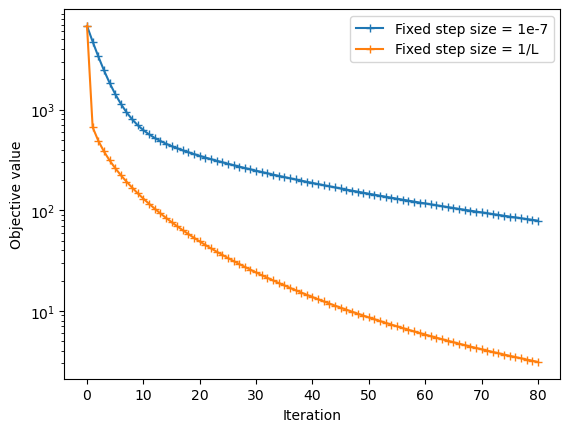

In [8]:
plt.plot(range(0,81),algo_GD_fixed.objective, label='Fixed step size = 1e-7', marker='+')
plt.plot(range(0,81),algo_GD_lip.objective, label='Fixed step size = 1/L', marker='+')
plt.legend()
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')

## Gradient descent default behaviour 

Gradient descent with a fixed step size is not guaranteed to converge. As the iterations get near the minimum, a fixed step could cause iterations oscillate around the minimum but not converge. 

The default behaviour of gradient descent is to use the Armijo step size rule. This is a "backtracking" line search method that iteratively reduces the step size until a sufficient decrease in the objective function is achieved. The Armijo rule ensures that the step size chosen at each iteration satisfies the condition:

$$ f(x_k + \alpha_k \nabla f(x_k)) \leq f(x_k) + c \alpha_k \nabla f(x_k)^T f(x_k) $$

where $ f $ is the objective function, $ x_k $ is the current point, $ \alpha_k $ is the step size, $\nabla f(x_k)$ is the search direction, and $c $ is a constant typically chosen in the interval $ (0, 1) $. This condition guarantees that the step size provides a sufficient decrease in the objective function, balancing between making progress and ensuring stability in the optimization process.


  0%|          | 0/80 [00:00<?, ?it/s]

Could not find a proper step_size in 40.0 loops. Consider increasing alpha or max_iterations.


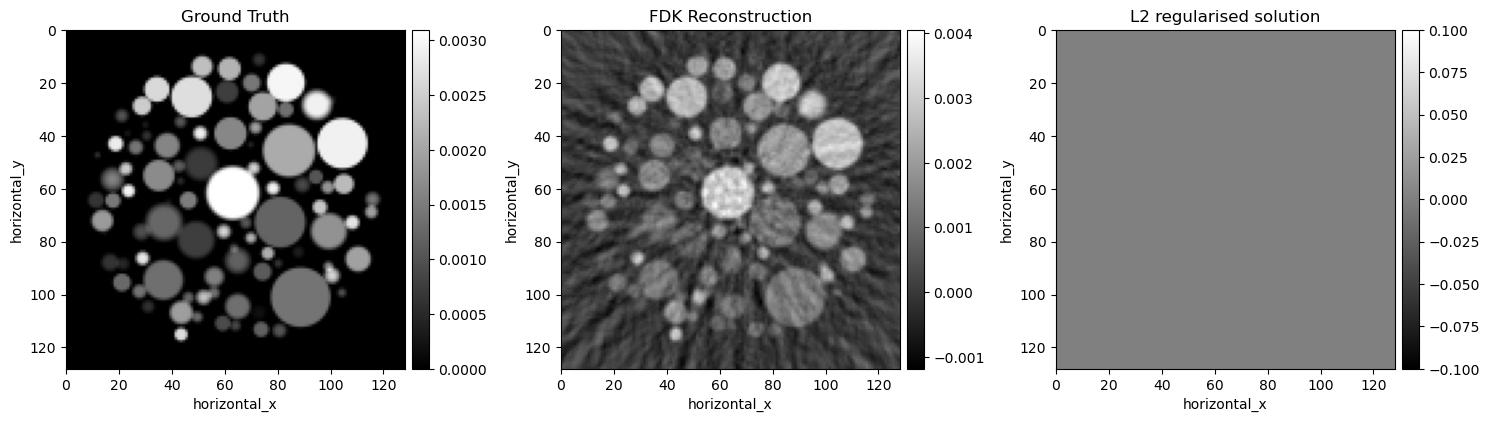

In [9]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo_default=GD(initial=ig.allocate(0), f=F)
try:
    algo_default.run(80)
except ValueError as e:
    print(e)
show2D([ground_truth, recon, algo_default.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3);


This does not work because in 40 iterations, the Armijo step size rule has not found a suitable step size. We define the step size rule explicitly and can alter the number of iterations in the step size rule to allow it to run without error: 

  0%|          | 0/80 [00:00<?, ?it/s]

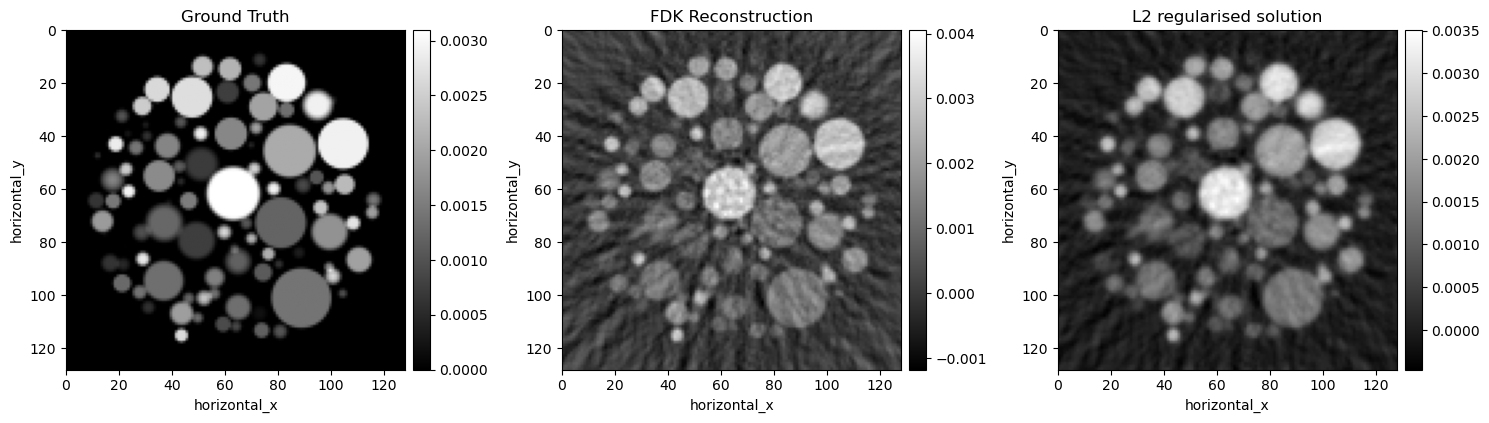

In [10]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
step_size_rule=ArmijoStepSizeRule(max_iterations=80)
algo_default=GD(initial=ig.allocate(0), f=F, step_size=step_size_rule)
algo_default.run(80)
show2D([ground_truth, recon, algo_default.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3)


We again plot the objective values against iteration numbers to compare the convergence rates: 

Text(0, 0.5, 'Objective value')

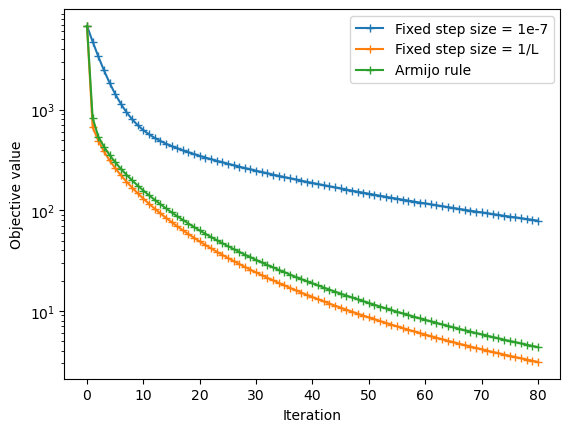

In [11]:
plt.plot(range(0,81),algo_GD_fixed.objective, label='Fixed step size = 1e-7', marker='+')
plt.plot(range(0,81),algo_GD_lip.objective, label='Fixed step size = 1/L', marker='+')
plt.plot(range(0,81),algo_default.objective, label='Armijo rule', marker='+')
plt.legend()
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')

We can see that the Armijo rule, for this case, gives similar results to the fixed step size, based on the Lipschitz constant. 

## Gradient descent custom step size rule 


In this example we create a custom `shrinking_step_size` rule, inheriting from the `StepSizeMethods.StepSizeRule` base class. This class defines a polynomial step size rule calculated as $$\alpha_t = \frac{\alpha_0}{(1 + k t)^p}$$ where $\alpha_t$ is the step size at iteration 
$t$, $\alpha_0$ is the initial step size, $k$ is the decay constant that controls the rate of decay and $p$ is the power determining the decay rate.

The idea is that with a higher initial step size, the algorithm can make large updates early, moving closer to an optimal region quickly and, 
as the step size decreases, the algorithm takes smaller steps, helping it settle into a more precise region near the optimum without overshooting. 

We build a custom step size rule in CIL to implement this. We define both a constructor and a `get_step_size` method:

Constructor:
- `__init__(self, initial=0.1, constant=0.1)`: Initializes the step size rule with an initial step size and a shrinkage factor.
  - `initial` (float): The initial step size to be used in the first iteration. Default is `0.1`.
  - `constant` (float): A constant that controls the rate of decay, the larger the number the quicker the decay. Default is `0.01`.
  - `power` (float): An integer that controls the type of decay e.g. `power = 1` is linear decay, `power = 2` is quadratic decay and `0 < power < 1` is sublinear decay. The larger the value of the power, the quicker the decay.  Default is `1`

Methods:
- `get_step_size(self, algorithm)`: Computes the step size for the current iteration of the algorithm.
  - `algorithm` (object): The optimization algorithm instance, which is expected to have an `iteration` attribute indicating the current iteration number.
  - Returns: The step size for the current iteration


  0%|          | 0/80 [00:00<?, ?it/s]

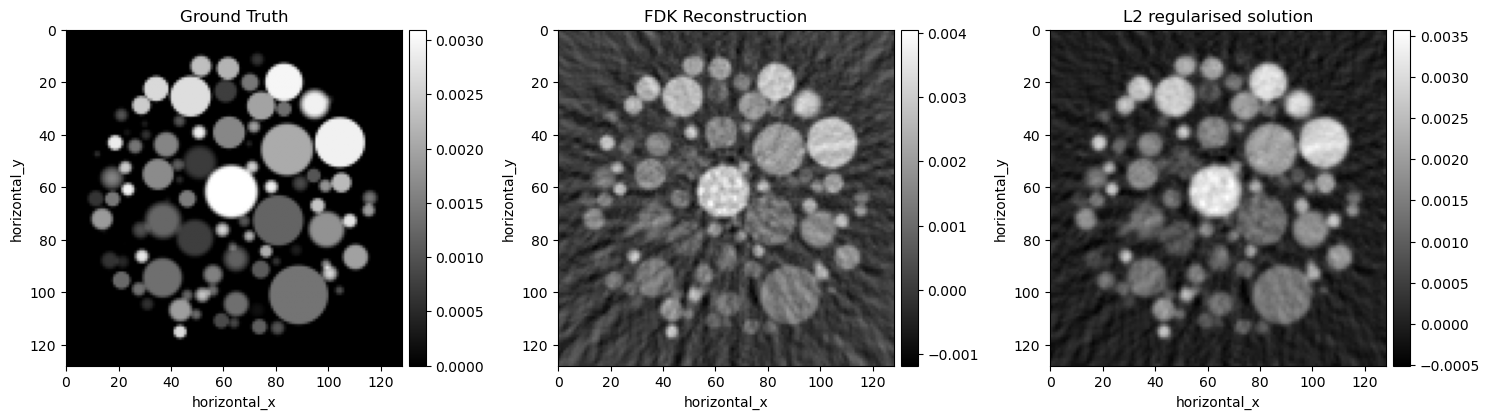

In [12]:
class shrinking_step_size(StepSizeMethods.StepSizeRule):
    def __init__(self, initial=0.1, constant=0.01, power=1):
        self.initial=initial
        self.constant=constant
        self.power=power
    
    def get_step_size(self, algorithm):
        return self.initial/((1+self.constant*algorithm.iteration)**self.power)
    
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
algo_custom=GD(initial=ig.allocate(0), f=F, step_size=shrinking_step_size(initial=1e-6) )
algo_custom.run(80)
show2D([ground_truth, recon, algo_custom.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3);


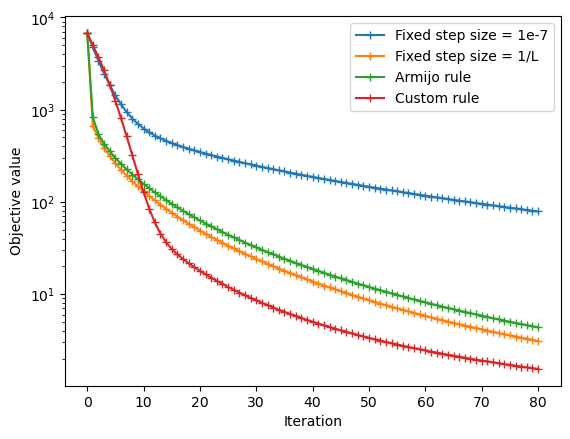

In [13]:
plt.plot(range(0,81),algo_GD_fixed.objective, label='Fixed step size = 1e-7', marker='+')
plt.plot(range(0,81),algo_GD_lip.objective, label='Fixed step size = 1/L', marker='+')
plt.plot(range(0,81),algo_default.objective, label='Armijo rule', marker='+')
plt.plot(range(0,81),algo_custom.objective, label='Custom rule', marker='+')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()

We see that within 15 iterations, the custom step size rule is able to achieve a similar objective value to the Armijo rule, without the additional calculations of the objective and without knowing the Lipschitz constant. With increasing iterations, the custom step size rule is achieving faster convergence than the Armijo rule. 

# Preconditioners 

To explain the concept of preconditioners, first look at the following toy problem. 

Consider solving, $$Ax^*=b$$ such that  $b=(0,0)^T$ and  $A=\begin{pmatrix}
1.0 & 0.0 \\
0.0 & 0.1 
\end{pmatrix}$. 

The unique solution to this is $x^*=(0,0)^T$. 

To visualise this problem we can plot the contours of  $f(x)=\| Ax-b\|_2^2$ for $x=[x_1,x_2]^T$ and see the minimum point, the green star,  at $x^*=[x_1^*,x_2^*]^T=(0,0)$. 

Note: The contour plot is a bit hard to interpret: the more yellow the lines the higher that point is above the minimum, the bottom of the valley. All points on the same line are the same height. 

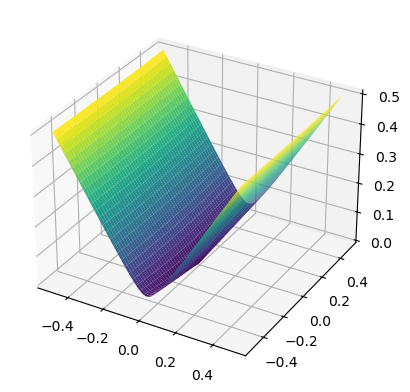

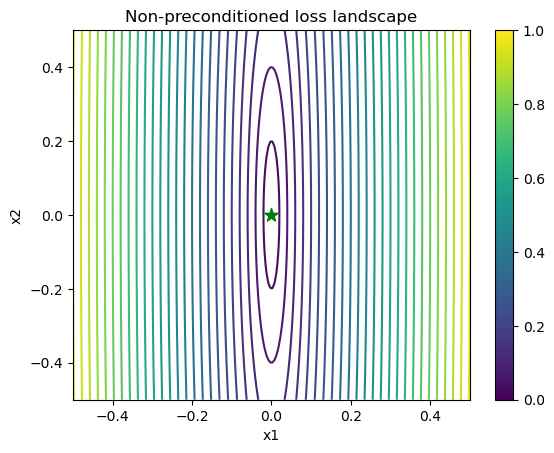

In [14]:
def f(x,y):
    return np.linalg.norm(np.matmul(np.array([[1.0,0.0],[0.0, 0.1]]), np.array([x,y]))-np.array([0,0]))


x_ = np.linspace(-0.5, 0.5, num=200)
y_ = np.linspace(-0.5, 0.5, num=200)
x,y = np.meshgrid(x_, y_)

levels = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        levels[i,j]=f(y_[j], x_[i])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf=ax.plot_surface(x, y, levels, cmap='viridis')

plt.show()

plt.figure()
c = plt.contour(x, y, levels, 30)
plt.scatter([0], [0],marker='*', color='green', s=100)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Non-preconditioned loss landscape')
plt.show()



The reason this is an ellipse is due to the fact that the matrix $A$ is ill-conditioned, it acts with a greater magnitude in some directions than other directions.

We can find a solution to this inverse problem by gradient descent, minimising $f(x)=\| Ax-b\|_2^2$ and plot the result using a custom callback. 

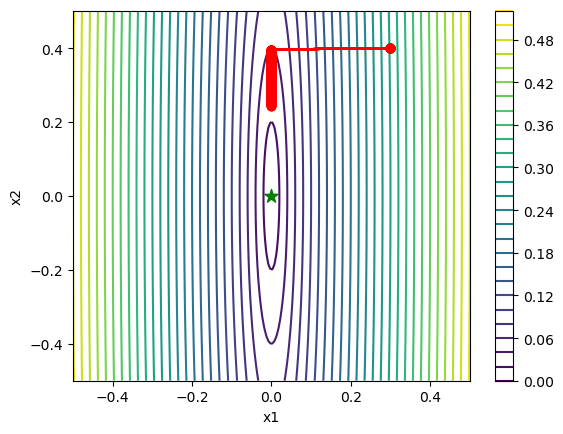

In [15]:
class plot_iterates(callbacks.Callback):
    
    def __init__(self, f):
      x_ = np.linspace(-0.5, 0.5, num=200)
      y_ = np.linspace(-0.5, 0.5, num=200)
      x,y = np.meshgrid(x_, y_)

      levels = np.zeros((200,200))
      for i in range(200):
          for j in range(200):
              levels[i,j]=f(y_[j], x_[i])\
                
      plt.contour(x, y, levels, 30)
      plt.colorbar()
      plt.xlabel('x1')
      plt.ylabel('x2')
      plt.scatter([0], [0],marker='*', color='green', s=100)
      self.save_points_x=[]
      self.save_points_y=[]
    
    def __call__(self, algorithm):
      self.save_points_x.append(algorithm.solution.as_array()[0])
      self.save_points_y.append(algorithm.solution.as_array()[1])
      plt.plot(self.save_points_x, self.save_points_y, color='red', marker='o')
  


initial = VectorData(np.array([0.3,0.4]))
b = VectorData(np.array([0.,0.]))
A = MatrixOperator(np.array([[1.,0.0],[0., 0.1]]))
F = 0.5*LeastSquares(A = A, b = b)
cb=plot_iterates(f)
algo=GD(initial=initial, f=F, step_size=1/F.L)
algo.run(50, callbacks=[cb])



We see after an initial large step, the algorithm now slows down as it hits the centre valley of the objective function. 

We precondition by the sensitivity of the matrix $A$ given by a vector $1/(A^T \mathbf{1})$. In the case of this example where the operator, $A$, acts at different scales in different directions, this preconditioner reduces the gradient step in larger directions, increasing it in smaller directions.  We can see that this stretches the loss landscape, making it "rounder" with less narrow valleys. 

In [16]:
precon=preconditioner.Sensitivity(operator=MatrixOperator(np.array([[1,0.0],[0.0, 0.1]])))

<Figure size 640x480 with 0 Axes>

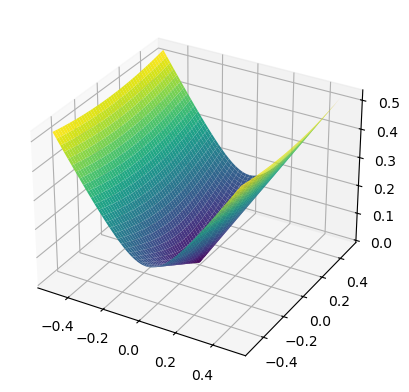

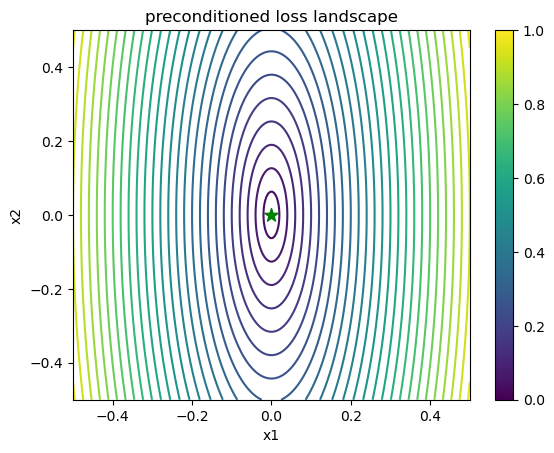

In [17]:
def f_precon(x,y):
    return np.linalg.norm(np.sqrt(precon.array.as_array())*(np.matmul(np.array([[1,0.0],[0.0, 0.1]]), np.array([x,y]))-np.array([0,0])))
plt.figure()

x_ = np.linspace(-0.5, 0.5, num=200)
y_ = np.linspace(-0.5, 0.5, num=200)
x,y = np.meshgrid(x_, y_)

levels = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        levels[i,j]=f_precon(y_[j], x_[i])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf=ax.plot_surface(x, y, levels, cmap='viridis')

plt.show()

plt.figure()
c = plt.contour(x, y, levels, 30)
plt.scatter([0], [0],marker='*', color='green', s=100)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('preconditioned loss landscape')
plt.show()


To apply this preconditioning to the gradient descent algorithm, we use the `Sensitivity` preconditioning provided in CIL, initialise this with the operator `A` and then pass this constructor for the Gradient descent algorithm class: `algo_precon=GD(initial=initial, f=F,  preconditioner=preconditioner.Sensitivity(operator=A), step_size=(1/F.L))`.  In the next cell, we run this algorithm and, similarly to above, we can plot the iterates of preconditioned gradient descent:

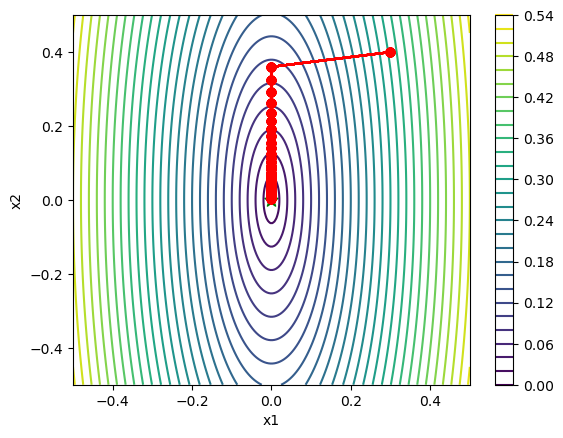

In [18]:

initial = VectorData(np.array([0.3,0.4]))
b = VectorData(np.array([0.,0.]))
A = MatrixOperator(np.array([[1.,0],[0., 0.1]]))
F = 0.5*LeastSquares(A = A, b = b)

cb=plot_iterates(f_precon)
algo_precon=GD(initial=initial, f=F,  preconditioner=preconditioner.Sensitivity(operator=A), step_size=(1/F.L))
algo_precon.run(50, callbacks=[cb])

The preconditioned gradient descent converges quicker:

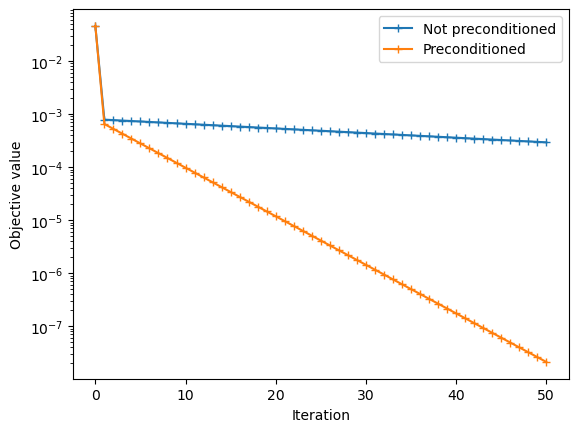

In [19]:
plt.plot(range(0,51),algo.objective, label='Not preconditioned', marker='+')
plt.plot(range(0,51),algo_precon.objective, label='Preconditioned', marker='+')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.yscale('log')
plt.legend()

Using a callback, we can see the progress of the algorithm and we see that the initial steps of the preconditioned algorithm get is much closer than in the non-preconditioned case. 

### Preconditioning CT example

We return to our CT example above. Again, we consider least squares with an L2 norm squared regularisation function solved by gradient descent with the Armijo step size rule. We use a callback to keep track of the mean squared error of the reconstructed image compared with the ground truth.

In [20]:
class mean_squared_error_callback(callbacks.Callback):
    def __init__(self, ground_truth):
        self.ground_truth=ground_truth
        self.errors=[]
    def __call__(self, algorithm):
        self.errors.append(np.linalg.norm(algorithm.solution.as_array()-self.ground_truth.as_array())**2)

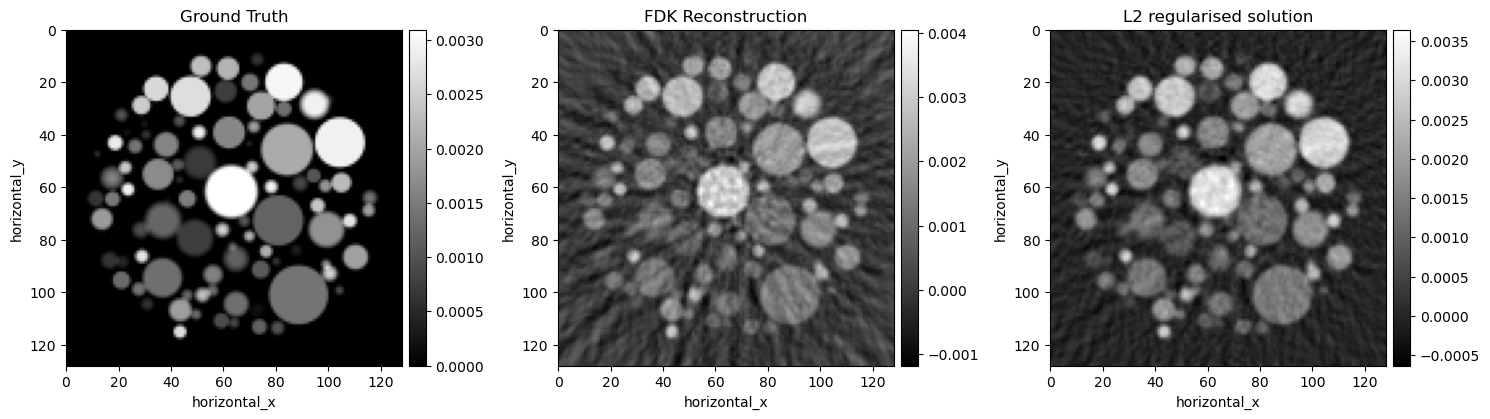

In [21]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
step_size_rule=ArmijoStepSizeRule(max_iterations=50)
algo=GD(initial=ig.allocate(0), f=F, step_size=step_size_rule) 

cb_no_precon=mean_squared_error_callback(ground_truth)
algo.run(300, callbacks=[cb_no_precon])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3);

We now add a preconditioner. This time another preconditioner provided in CIL,  `AdaptiveSensitivity`, in each call to the preconditioner the `gradient` is multiplied by $(x+\delta) /(A^T \mathbf{1})$ where $A$ is an operator,  $\mathbf{1}$ is an object in the range of the operator filled with ones. The point $x$ is the current iteration, or a reference image,  and $\delta$ is a small positive float. The small positive float is added to ensure that pixels with zero value can still be updated.

The preconditioner is called an Expectation Maximisation, used in MLEM and BSREM algorithms. It is similar to the sensitivity preconditioner seen above but in addition scales the gradient by a reference image, providing a bigger update in areas of the image where there is more absorption.    For more information see: 
-  R. Twyman et al., "An Investigation of Stochastic Variance Reduction Algorithms for Relative Difference Penalized 3D PET Image Reconstruction," in IEEE Transactions on Medical Imaging, vol. 42, no. 1, pp. 29-41, Jan. 2023, doi: 10.1109/TMI.2022.3203237.
-  Sangtae Ahn and J. A. Fessler, "Globally convergent image reconstruction for emission tomography using relaxed ordered subsets algorithms," in IEEE Transactions on Medical Imaging, vol. 22, no. 5, pp. 613-626, May 2003, doi: 10.1109/TMI.2003.812251.

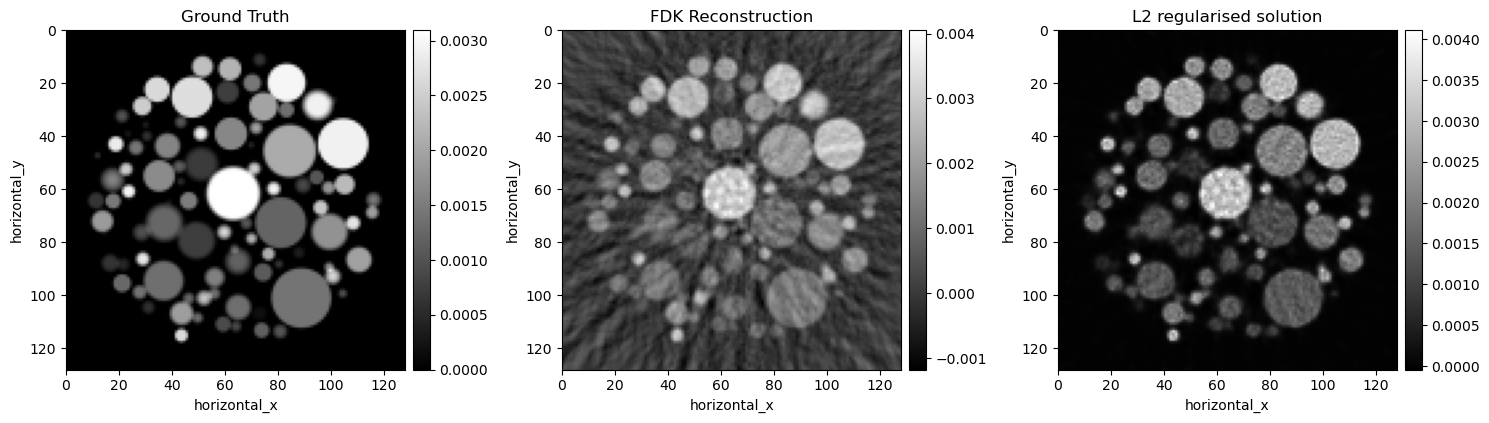

In [22]:
alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = 0.5*LeastSquares(A = A, b = absorption)+ alpha*L2NormSquared()
precon=preconditioner.AdaptiveSensitivity(operator=A)
step_size_rule=ArmijoStepSizeRule(max_iterations=50)
algo_precon=GD(initial=ig.allocate(0), f=F , preconditioner=precon, step_size=step_size_rule)

cb_precon=mean_squared_error_callback(ground_truth)
algo_precon.run(300, callbacks=[cb_precon])
show2D([ground_truth, recon, algo_precon.solution], title = ['Ground Truth', 'FDK Reconstruction', 'L2 regularised solution'], origin = 'upper', num_cols = 3);

We can plot the mean squared error of the reconstructed image compared with the ground truth and how this changes with iteration number:

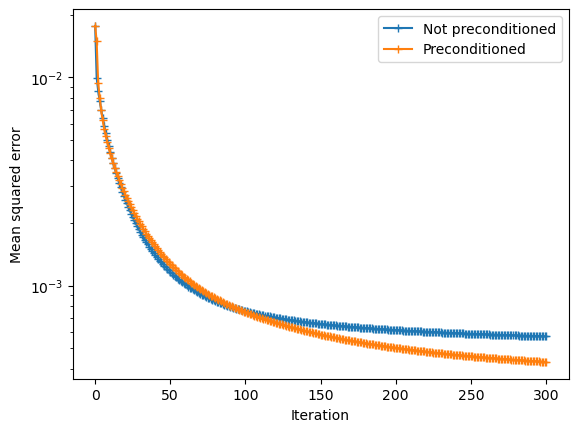

In [23]:
plt.plot(range(0,301),cb_no_precon.errors, label='Not preconditioned', marker='+')
plt.plot(range(0,301),cb_precon.errors, label='Preconditioned', marker='+')
plt.xlabel('Iteration')
plt.ylabel('Mean squared error')
plt.yscale('log')

plt.legend()

We see slightly improved results with the preconditioner. In particular, in the image plots, the preconditioned result has not overfitted to the noise in the background. 

# Summary of the notebook
This notebook has covered:
- Different step size and preconditioners that can be used with gradient descent algorithms in CIL (GD, ISTA and FISTA)
- Compared different step size rules for a noisy CT reconstruction problem
- A demonstration of a custom step size rule
- A custom callback to plot the iterates of the algorithm
- Comparing a preconditioned and non preconditioned gradient descent algorithm for a simple 2D problem and a CT reconstruction problem
- A custom callback to calculate the mean squared error between the ground truth and the solution at each iteration